<a href="https://colab.research.google.com/github/eel-eel-eel/ric1340/blob/main/ch05_02_03_classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 環境構築

※2023/04のGoogle colaboratoryのPython3.10へのアップデートに伴い、使用するライブラリを変更したため、コードを大幅に修正

Google Driveをマウント
（データセットや学習済みモデルを格納する）

パスワードを求められた場合はリンクをクリックし、Googleアカウントにログインして表示された文字列を入力する。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[ja]==4.29.1 datasets==2.12.0 evaluate==0.4.0
!pip install --upgrade accelerate==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 85.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━

## データセットの前処理

データセット（livedoor ニュースコーパス）のダウンロード

In [ ]:
!mkdir -p /content/drive/MyDrive/bert/5_1_livedoor_news

In [ ]:
cd /content/drive/MyDrive/bert/5_1_livedoor_news

/content/drive/MyDrive/bert/5_1_livedoor_news


In [ ]:
import urllib.request

dataset_url = "https://www.rondhuit.com/download/ldcc-20140209.tar.gz"
urllib.request.urlretrieve(dataset_url, "ldcc-20140209.tar.gz")

('ldcc-20140209.tar.gz', <http.client.HTTPMessage at 0x7f79fcdc6ec0>)

In [ ]:
!tar -zxvf ldcc-20140209.tar.
!rm /content/drive/MyDrive/bert/5_1_livedoor_news/ldcc-20140209.tar.gz

tar (child): ldcc-20140209.tar.: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


データセットの展開結果を確認

In [ ]:
!ls -l /content/drive/MyDrive/bert/5_1_livedoor_news/text

total 39
-rw------- 1 root root  223 May 19 16:10 CHANGES.txt
drwx------ 2 root root 4096 Feb  9  2014 dokujo-tsushin
drwx------ 2 root root 4096 Feb  9  2014 it-life-hack
drwx------ 2 root root 4096 Feb  9  2014 kaden-channel
drwx------ 2 root root 4096 Feb  9  2014 livedoor-homme
drwx------ 2 root root 4096 Feb  9  2014 movie-enter
drwx------ 2 root root 4096 Feb  9  2014 peachy
-rw------- 1 root root 2182 May 19 16:10 README.txt
drwx------ 2 root root 4096 Feb  9  2014 smax
drwx------ 2 root root 4096 Feb  9  2014 sports-watch
drwx------ 2 root root 4096 Feb  9  2014 topic-news


In [ ]:
import glob
from collections import defaultdict

label2id = defaultdict(lambda: len(label2id))

for id, path in enumerate(glob.glob('text/**/', recursive=False)):
  label = path.split('/')[-2]
  label2id[label]

label2id

defaultdict(<function __main__.<lambda>()>,
            {'dokujo-tsushin': 0,
             'livedoor-homme': 1,
             'kaden-channel': 2,
             'smax': 3,
             'topic-news': 4,
             'peachy': 5,
             'movie-enter': 6,
             'it-life-hack': 7,
             'sports-watch': 8})

データセット（表形式）の作成

※数分から数十分かかるので、一度実行済みでdatasets.tsvがある場合は飛ばしてOK

In [ ]:
import pandas as pd
columns = ["id", "label", "title", "text"]
df_dataset = pd.DataFrame(columns=columns)

for file_name in glob.glob("text/**/*", recursive=False):
  if "LICENCE" in file_name:
    continue
  with open(file_name, 'r') as f:
    lines = f.readlines()
    label = file_name.split('/')[-2]
    id = label2id[label]
    title = lines[2].strip("\n")

    text = "".join(lines[3:])
    text = "".join(text.split())

    record = pd.DataFrame([[id, label, title, text]], columns=columns)
    df_dataset = pd.concat([df_dataset, record], ignore_index=True)
id2label = {value: key for key, value in label2id.items()}

df_dataset.to_csv('title_dataset/dataset.tsv', sep='\t', index=False)

In [ ]:
import pandas as pd
df_dataset = pd.read_csv('title_dataset/dataset.tsv', sep='\t')
label2id = {label: id for id, label in df_dataset[['id', 'label']].values}
id2label = {id: label for id, label in df_dataset[['id', 'label']].values}
df_dataset

,id,label,title,text
0,0,dokujo-tsushin,その後の結婚生活を占う披露宴での費用分担,女性の夢と憧れを実現する場といえば、結婚披露宴だ。そこは、女性の「プロデュース力」が試される...
1,0,dokujo-tsushin,韓国人の彼氏が徴兵されることについて,独女編集部、独女代表Mです。韓国では、天安艦事件が起こり物々しい雰囲気に包まれていますが、日...
2,0,dokujo-tsushin,「おばさん」と呼ばれたら？ そのときあなたは？,「わからないことがあったら、あそこにいる『おばさん』に聞いて」という同僚男性の声に気づいて顔...
3,0,dokujo-tsushin,既婚女性に聞く！ 町選びのポイントとは？,今秋、結婚予定のミホさん（27歳会社員）は、このところ結婚後の住まいのことで頭がいっぱいだ。...
4,0,dokujo-tsushin,友達が多い人って、実は性格がよくない！？,子供の頃、「友達はたくさん作りなさい」と学校でも家庭でも教わらなかっただろうか？偏らず、いろ...
...,...,...,...,...
7380,8,sports-watch,【Sports Watch】宮里藍、太極拳スイングを語る,2010年、日本人最多の5勝を挙げ、9週に渡って世界ランク1位にも輝く大活躍を遂げたプロゴル...
7381,8,sports-watch,【Sports Watch】巨人・坂本、今季を振り返る「なんなんでしょうかね」,14日深夜、フジテレビ「すぽると！」では、巨人・坂本勇人のインタビューを放送、不本意な一年と...
7382,8,sports-watch,【Sports Watch】ROOKIES俳優も不信感、進歩なき大晦日格闘技イベント,大晦日の格闘技イベント「Dynamite!!」開催が近づいてきた。対戦カードも徐々に出揃いは...
7383,8,sports-watch,【Sports Watch】大健闘・村上佳菜子、「ビックリしてフワフワ」,中国北京で開催されたフィギュアGPファイナルは、16歳・村上佳菜子が日本勢ではトップとなる3...


データセットをランダムで並べ替え

In [ ]:
random_seed = 42
df_dataset = df_dataset.sample(frac=1, random_state=random_seed)
df_dataset.head()

,id,label,title,text
7261,8,sports-watch,【Sports Watch】カズ、松井にエール「僕に言わせれば赤ん坊」,5日放送、日本テレビ系「NEWSZERO」では、日本代表・松井大輔がゲストで出演した。W杯の...
4489,5,peachy,ダイエット＆美肌に！今、きのこが熱い,写真一覧（6件）薄着になるにつれて気になってくるのが、お腹や二の腕、脚に付いたヤバめのお肉…...
1539,2,kaden-channel,【話題】アップルがロック解除の特許獲得で他社のスマホはどうなる？,アップルが「iPhone」などで採用しているスライド式のロック解除機能。このスライド式解除機...
3532,4,topic-news,指原莉乃、バッシングに弁明も風当たりの強さ変わらず,スキャンダルにより、AKB48からHKT48へ移籍することになった指原莉乃。23日、自身のバ...
6418,7,it-life-hack,漫画家/イラストレーター志望のクリエイターのたまご必見！ デジタルでの制作環境が全て揃うレビ...,「Ultrabook」の専門コンテンツ「Ultrabooker.jp」（ウルトラブッカージェ...


タイトルと本文をつなげたデータセットも作成

In [ ]:
df_dataset['all'] = df_dataset['title'] + ':' + df_dataset['text']

データセットの分割

In [ ]:
from sklearn.model_selection import train_test_split
df_dataset_train, df_dataset_dev = train_test_split(df_dataset, test_size=0.2, shuffle=False, random_state=random_seed)
df_dataset_dev, df_dataset_test = train_test_split(df_dataset_dev, test_size=0.5, shuffle =False, random_state=random_seed)
print(len(df_dataset_train), len(df_dataset_dev), len(df_dataset_test))

5908 738 739


In [ ]:
df_dataset_train.head()

,id,label,title,text,all
7261,8,sports-watch,【Sports Watch】カズ、松井にエール「僕に言わせれば赤ん坊」,5日放送、日本テレビ系「NEWSZERO」では、日本代表・松井大輔がゲストで出演した。W杯の...,【Sports Watch】カズ、松井にエール「僕に言わせれば赤ん坊」:5日放送、日本テレビ...
4489,5,peachy,ダイエット＆美肌に！今、きのこが熱い,写真一覧（6件）薄着になるにつれて気になってくるのが、お腹や二の腕、脚に付いたヤバめのお肉…...,ダイエット＆美肌に！今、きのこが熱い:写真一覧（6件）薄着になるにつれて気になってくるのが、...
1539,2,kaden-channel,【話題】アップルがロック解除の特許獲得で他社のスマホはどうなる？,アップルが「iPhone」などで採用しているスライド式のロック解除機能。このスライド式解除機...,【話題】アップルがロック解除の特許獲得で他社のスマホはどうなる？:アップルが「iPhone」...
3532,4,topic-news,指原莉乃、バッシングに弁明も風当たりの強さ変わらず,スキャンダルにより、AKB48からHKT48へ移籍することになった指原莉乃。23日、自身のバ...,指原莉乃、バッシングに弁明も風当たりの強さ変わらず:スキャンダルにより、AKB48からHKT...
6418,7,it-life-hack,漫画家/イラストレーター志望のクリエイターのたまご必見！ デジタルでの制作環境が全て揃うレビ...,「Ultrabook」の専門コンテンツ「Ultrabooker.jp」（ウルトラブッカージェ...,漫画家/イラストレーター志望のクリエイターのたまご必見！ デジタルでの制作環境が全て揃うレビ...


モデルに合わせたデータセットの作成、保存


In [ ]:
!mkdir -p /content/drive/MyDrive/bert/5_1_livedoor_news/title_dataset
!mkdir -p /content/drive/MyDrive/bert/5_1_livedoor_news/all_dataset

In [ ]:
# タイトルのみのデータセット
df_dataset_train.to_csv('title_dataset/train.tsv',  columns=['id', 'label', 'title'], sep='\t', index=False)
df_dataset_dev.to_csv('title_dataset/dev.tsv',  columns=['id', 'label', 'title'], sep='\t', index=False)
df_dataset_test.to_csv('title_dataset/test.tsv',  columns=['id', 'label', 'title'], sep='\t', index=False)

# タイトル＋本文のデータセット
df_dataset_train.to_csv('all_dataset/train.tsv',  columns=['id', 'label', 'all'], sep='\t', index=False)
df_dataset_dev.to_csv('all_dataset/dev.tsv',  columns=['id', 'label', 'all'], sep='\t', index=False)
df_dataset_test.to_csv('all_dataset/test.tsv',  columns=['id', 'label', 'all'], sep='\t', index=False)


## 日本語BERTの事前学習モデルの準備


In [ ]:
import pandas as pd
df_title_dataset_train = pd.read_csv('title_dataset/train.tsv', sep='\t', usecols=['id', 'title'])
df_title_dataset_dev = pd.read_csv('title_dataset/dev.tsv', sep='\t', usecols=['id', 'title'])
df_title_dataset_test = pd.read_csv('title_dataset/test.tsv', sep='\t', usecols=['id', 'title'])

In [ ]:
from datasets import Dataset
from datasets import concatenate_datasets, load_dataset, DatasetDict

d = {
    'train':Dataset.from_pandas(df_title_dataset_train.loc[:, ["title", "id"]]),
     'dev':Dataset.from_pandas(df_title_dataset_dev.loc[:, ["title", "id"]]),
     'test':Dataset.from_pandas(df_title_dataset_test.loc[:, ["title", "id"]])
     }

dataset = DatasetDict(d)
dataset.set_format("pt")

#BertForSequenceClassificationの学習時のフォーマットに変更
dataset = dataset.rename_column("title", "text")
dataset = dataset.rename_column("id", "labels")

トークナイザの動作確認

In [ ]:
from transformers import BertJapaneseTokenizer
# cl-tohokuのモデルは512トークンまで対応しているが、512トークンではモデルがcolabのGPUメモリに乗らないため簡略化
n_tokens = 256

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
tokenizer.model_max_length = n_tokens
tokenizer.tokenize('今日はいい天気ですね。')

['今日', 'は', 'いい', '天気', 'です', 'ね', '。']

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5908 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/739 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate
import numpy as np
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average="macro")

## クラス分類モデルのファインチューニング（タイトルのみ）

In [ ]:
!mkdir -p /content/drive/MyDrive/bert/5_1_livedoor_news/model/

In [ ]:
import torch
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
model = BertForSequenceClassification.from_pretrained(
    'cl-tohoku/bert-base-japanese-whole-word-masking',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
batch_size=16
epoch=3
lr=1e-5
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert/5_1_livedoor_news/model/",
    learning_rate=lr,
    optim='adamw_torch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    evaluation_strategy="steps",
    push_to_hub=False,
    seed=random_seed,
    load_best_model_at_end=True,
    save_total_limit=1,
    save_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,F1
500,1.032800,0.519565,0.833152
1000,0.416200,0.442526,0.850569


TrainOutput(global_step=1110, training_loss=0.6883709813023473, metrics={'train_runtime': 184.7625, 'train_samples_per_second': 95.929, 'train_steps_per_second': 6.008, 'total_flos': 363549826261512.0, 'train_loss': 0.6883709813023473, 'epoch': 3.0})

テストデータの推論

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)
trues = dataset["test"]["labels"].to('cpu').detach().numpy().copy()

In [ ]:
print('精度　 :{:.3f}'.format(accuracy.compute(predictions=preds, references=trues)["accuracy"]))
print('適合率 :{:.3f}'.format(precision.compute(predictions=preds, references=trues, average="macro")["precision"]))
print('再現率 :{:.3f}'.format(recall.compute(predictions=preds, references=trues, average="macro")["recall"]))
print('f-1値  :{:.3f}'.format(f1.compute(predictions=preds, references=trues, average="macro")["f1"]))

精度　 :0.861
適合率 :0.863
再現率 :0.847
f-1値  :0.851


0 dokujo-tsushin
1 livedoor-homme
2 kaden-channel
3 smax
4 topic-news
5 peachy
6 movie-enter
7 it-life-hack
8 sports-watch


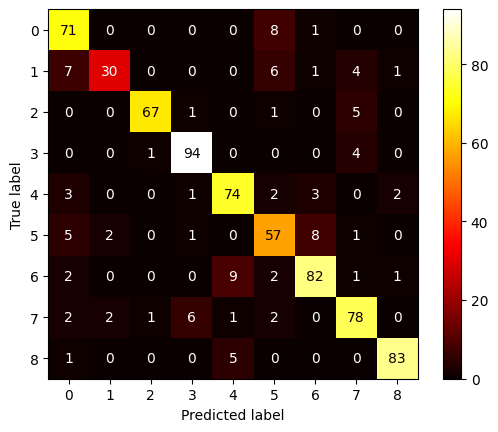

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = [v for v in label2id.values()]

cm = confusion_matrix(trues, preds, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.hot, values_format='d')

for k,v in label2id.items(): print(v, k)

In [ ]:
torch.cuda.empty_cache()

## クラス分類モデルのファインチューニング（タイトル＋本文）

データセットの作成

In [ ]:
df_all_dataset_train = pd.read_csv('all_dataset/train.tsv', sep='\t', usecols=['id', 'all'])
df_all_dataset_dev = pd.read_csv('all_dataset/dev.tsv', sep='\t', usecols=['id', 'all'])
df_all_dataset_test = pd.read_csv('all_dataset/test.tsv', sep='\t', usecols=['id', 'all'])

In [ ]:
d = {
    'train':Dataset.from_pandas(df_all_dataset_train.loc[:, ["all", "id"]]),
     'dev':Dataset.from_pandas(df_all_dataset_dev.loc[:, ["all", "id"]]),
     'test':Dataset.from_pandas(df_all_dataset_test.loc[:, ["all", "id"]])
     }

dataset = DatasetDict(d)
dataset.set_format("pt")

#BertForSequenceClassificationの学習時のフォーマットに変更
dataset = dataset.rename_column("all", "text")
dataset = dataset.rename_column("id", "labels")

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5908 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/739 [00:00<?, ? examples/s]

モデルの作成

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'cl-tohoku/bert-base-japanese-whole-word-masking',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
batch_size=16
epoch=3
lr=1e-5
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert/5_1_livedoor_news/model/",
    learning_rate=lr,
    optim='adamw_torch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    evaluation_strategy="steps",
    push_to_hub=False,
    seed=random_seed,
    load_best_model_at_end=True,
    save_total_limit=1,
    save_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,F1
500,0.792800,0.314731,0.893336
1000,0.198300,0.229350,0.919987


TrainOutput(global_step=1110, training_loss=0.4608778446644276, metrics={'train_runtime': 823.6021, 'train_samples_per_second': 21.52, 'train_steps_per_second': 1.348, 'total_flos': 2331836719736832.0, 'train_loss': 0.4608778446644276, 'epoch': 3.0})

テストデータの推論

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)
trues = dataset["test"]["labels"].to('cpu').detach().numpy().copy()

In [ ]:
print('精度　 :{:.3f}'.format(accuracy.compute(predictions=preds, references=trues)["accuracy"]))
print('適合率 :{:.3f}'.format(precision.compute(predictions=preds, references=trues, average="macro")["precision"]))
print('再現率 :{:.3f}'.format(recall.compute(predictions=preds, references=trues, average="macro")["recall"]))
print('f-1値  :{:.3f}'.format(f1.compute(predictions=preds, references=trues, average="macro")["f1"]))

精度　 :0.945
適合率 :0.943
再現率 :0.940
f-1値  :0.941


0 dokujo-tsushin
1 livedoor-homme
2 kaden-channel
3 smax
4 topic-news
5 peachy
6 movie-enter
7 it-life-hack
8 sports-watch


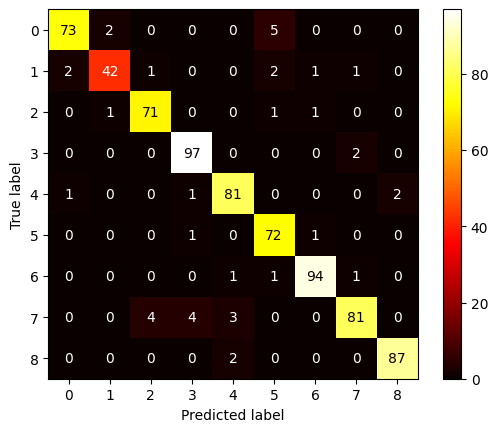

In [ ]:
labels = [v for v in label2id.values()]

cm = confusion_matrix(trues, preds, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.hot, values_format='d')

for k,v in label2id.items(): print(v, k)

モデルの保存

In [ ]:
!mkdir -p /content/drive/MyDrive/bert/5_1_livedoor_news/model/fine-tuned_model

In [ ]:
trainer.save_model("/content/drive/MyDrive/bert/5_1_livedoor_news/model/fine-tuned_model")